> Created on Sat Aug 26 17:34:35 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

# 3.9 强化学习

## 3.9.1 多（$k$）臂赌博机与动作-价值方法（Action-value Methods）

### 3.9.1.1 多（$k$）臂赌博机（Multi-armed Bandits）问题和算法实现

$k$臂赌博机问题，源于想象赌徒在一排老虎机（单臂赌博机）前，决定玩哪台机器，每台机器玩多少次，以什么顺序玩，及是继续使用当前的机器还是尝试不同的机器。每台机器从特定于该机器的概率分布中提供随机收益（这是先验未知的），而赌徒的目标是通过拉动一系列老虎机的控制杆以获得最大的收益。在每次试验中，赌徒面临的关键权衡是“开发（exploitation）”具有当前最高预期收益估计的机器，还是“试探（exploration）”以获得更多关于其它机器预期收益的信息<sup>[Multi-armed bandit, <https://en.wikipedia.org/wiki/Multi-armed_bandit#:~:text=In%20probability%20theory%20and%20machine,when%20each%20choice%27s%20properties%20are>]</sup>。拉动不同老虎机控制杆的动作（actions），每一个动作在被选择时都有一个期望或平均收益/奖励（reward），称为这个动作的价值（value）。将在$t$时刻选择的动作记作$A_t$，并将对应的收益记作$R_t$。任一动作$a$对应的真实价值记作$q_*(a)$，是给定动作$a$时收益的期望：$q_*(a) \doteq \mathbb{E}\left[R_t \mid A_t=a\right]$。虽然并不能确切的知道动作的价值，但是可以进行估计，将动作$a$在时刻$t$时的价值估计记作$Q_t(a)$，且希望该值趋近$q_*(a)$（真实价值/期望收益）。

开发/试探的权衡中，“开发”是利用当前所知关于动作价值的知识（信息），选择具有最大估计价值的动作，以获得基于已有知识条件下的最大收益；而“试探”则是尝试随机动作，不受已有动作价值的约束，来探索未知环境，选择的动作不再一定是具有最大估计价值的动作。“开发”为最大化当前时刻的期望收益，但长远来看，“试探”可能会带来总体收益的最大化。因为“开发”和“试探”不可能同时进行，因此二者之间存在冲突，需要寻找权衡二者之间关系以最大化预期累积收益的平衡方法。                              
通过价值的估计选择动作的方法统称为动作-价值方法。动作价值的真实值是选择这个动作时的期望收益。因此可以通过计算实际收益的平均值来估计动作的价值，有$Q_t(a) \doteq \frac{\text { sum of rewards when } a \text { taken prior to } t}{\text { number of times } a \text { taken prior to } t}=\frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_i=a}} , (1) $（$Q_t(a) \doteq \frac{t \text { 时刻前通过执行动作 } a \text { 得到的收益总和 }}{t \text { 时刻前执行动作 } a \text { 的次数 }}=\frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_i=a}}$），式中，$\mathbb{1}_{\text {predicate }} $表示断言（predicate）为真其值为1，否则为0的随机变量。当分母为0时，将$Q_t(a)$定义为某个默认值，例如值为0；当分母趋向于无穷大时，根据大数定律（the law of large numbers），$Q_t(a)$会收敛到$q_*(a)$。因为每次对一个动作价值的估计，都为该动作已有和当前收益的均值，所以该种估计动作价值的方法称为采样平均方法（sample-average method）（采样平均方法为估计动作价值的一种方法，且不一定为最好的方法）。使用$t$时刻前动作价值的估计结果，在$t$时刻选择具有最高估计值的动作，即为开发/试探权衡中的“开发”，记作$A_t \doteq \underset{a}{\arg \max } Q_t(a)$，式中，$\underset{a}{\arg \max }$是对应$Q_t(a)$动作价值中具有最大值的动作$a$。

“开发”的权衡策略专注于当前估计的动作价值，为了避免陷入局部最优而采取“试探”的策略，以独立于动作-价值估计的方式偶尔（例如一个很小的概率$\epsilon$）从所有动作中等概率的随机选择一个动作。

对于$k$臂赌博机问题，假设$k=10$（有10个老虎机），每个老虎机都有特定于该机器提供奖励的概率分布，例如下图中假设拉动每个老虎机控制杆动作收益的真实值（期望值）$q_*(a)$来自于均值为0和方差为1的标准正态分布，然后其实际的收益从均值为$q_*(a)$单位方差的正态分布中生成（实验中，每个老虎机的随机采样样本数配置为2000），从而拉动不同老虎机控制杆后获得的动作真实值为$q_*(a), a=1, \ldots, 10$，对应到时刻$t$，选择$A_t$（时刻$t$时的动作）时，实际的收益$R_t$（时刻$t$时的收益）则由一个均值为$q_*\left(A_t\right)$，方差为1的正态分布决定。

In [3]:
%load_ext autoreload 
%autoreload 2
from usda.migrated_project.RL_an_introduction import chapter02
import usda.data_visual as usda_vis

import matplotlib
%matplotlib inline
matplotlib.style.use('default') 

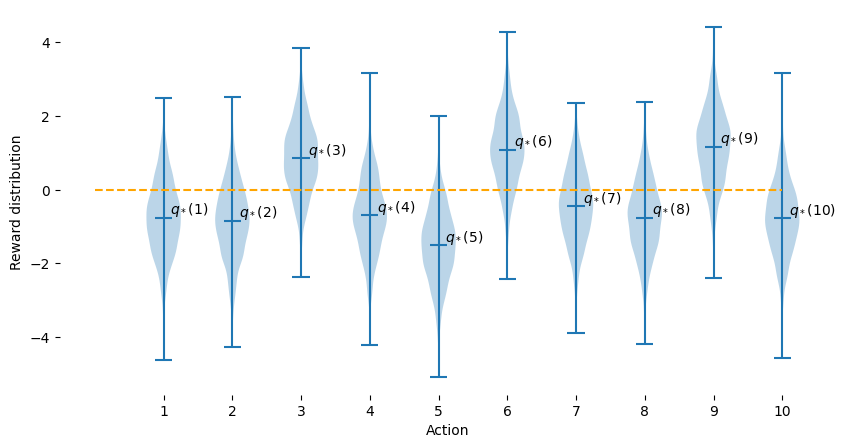

In [4]:
chapter02.figure_2_1(k=10,num=2000,seed=3467)

基于采样平均方法公式（1），就一个动作而言，令$R_i$表示这一动作被选择$i$次后获得的收益，$Q_n$表示被选择$n-1$次后估计的动作价值，简写为$Q_n \doteq \frac{R_1+R_2+\cdots+R_{n-1}}{n-1}$。上述公式计算时需要维护所有收益的记录， 以便在估计动作价值时进行计算，这无疑增加了内存使用量和计算成本，因此设计增量式公式（incremental formulas）以小而恒定的计算来更新动作价值的平均值，其推演过程如下，

$$
\begin{aligned}
Q_{n+1} & =\frac{1}{n} \sum_{i=1}^n R_i \\
& =\frac{1}{n}\left(R_n+\sum_{i=1}^{n-1} R_i\right) \\
& =\frac{1}{n}\left(R_n+(n-1) \frac{1}{n-1} \sum_{i=1}^{n-1} R_i\right) \\
& =\frac{1}{n}\left(R_n+(n-1) Q_n\right) \\
& =\frac{1}{n}\left(R_n+n Q_n-Q_n\right) \\
& =Q_n+\frac{1}{n}\left[R_n-Q_n\right], (2)
\end{aligned}
$$

公式（2）对$n=1$同样有效，对任意$Q_1$有$Q_2=R_1$。对于每一新的动作收益，公式（2）计算方法只需要存储$Q_n$和$n$，其一般的形式可写为$\text { NewEstimate } \leftarrow \text { OldEstimate }+ \text { StepSize }[\text { Target }- \text { OldEstimate }] ,(3)$（$新估计值 \leftarrow 旧估计值 + 步长 \times [目标 - 旧估计值]$），式中，$[目标 - 旧估计值]$是估计值的误差，误差会随着向目标（target）靠近的每一步而减小。公式（2）中的目标为第$n$次的收益，步长（stepsize）记作$n$，更一般的步长表示为$\alpha$或者$\alpha_t(a)$。

多臂赌博机算法的伪代码可以写为：

```algorithm
% WGAN
\begin{algorithm}
\caption{A simple bandit algorithm}
\begin{algorithmic}
\FOR{$a = 1$ to $k$(\textbf{Initialize})}
\STATE  $Q(a) \leftarrow 0$
\STATE $N(a) \leftarrow 0$
\ENDFOR
\WHILE{(\textbf{Loop forever})}
\STATE $A \leftarrow \begin{cases}\operatorname{argmax}_a Q(a) & \text { with probability } 1-\varepsilon \quad \text { (breaking ties randomly) } \\ \text { a random action } & \text { with probability } \varepsilon\end{cases} $
\STATE $R \leftarrow \operatorname{bandit}(A)$
\STATE $N(A) \leftarrow N(A)+1$
\STATE $Q(A) \leftarrow Q(A)+\frac{1}{N(A)}[R-Q(A)]$
\ENDWHILE
\end{algorithmic}
\end{algorithm}
```

对应到 Shangtong Zhang 书写的代码为：

In [6]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward


def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

其中，动作价值估计$Q(a)$（$Q(A)$）对应变量`q_estimation`；不同动作计数$N(a)$（$N(A)$）对应变量`action_count`；开发/试探权衡中，动作选择$A$对应语句为（`act()`方法）：

```python
if np.random.rand() < self.epsilon:
    return np.random.choice(self.indices)
...
q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])    
```

$t$时刻所选动作$A$的收益（奖励）$R$对应语句`reward = np.random.randn() + self.q_true[action]`；计算动作价值（$Q(A)$）时，使用采样平均方法的增量式实现（`sample_averages=True`），对应语句`self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]`。

下述使用迁移至`USDA`库的代码实现下述计算（或从 [Shangtong Zhang 代码实现仓库](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction)下载执行），比较开发/试探权衡，配置不同的$\epsilon$，值为0时，为完全“开发”模式，无“试探”过程；值为0.1时和0.01时，考虑了以较小几率加入”试探“的过程，0.1的值相对0.01具有更多”试探“的机会。配置执行迭代次数为2000次，每一次迭代选择拉动老虎机控制杆的次数（一个时刻选择一台拉动）为1000次，每一新一轮迭代都需要调用`reset()`方法随机重置每个老虎机的奖励$q_*(a)$（动作的真实价值）`q_true`；$t$时刻动作的价值估计$Q_t(a)$，`q_estimation`；已执行的动作计数$N(A)$（已拉动每台老虎机控制杆次数），`action_count`；及具有最大价值的动作`best_action`，并从头执行1000次动作配置`time=0`。

In [4]:
runs=2000
time=1000
epsilons = [0, 0.1, 0.01]

bandits = [chapter02.Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
est_action_counts, rewards = chapter02.simulate(runs, time, bandits)

100%|█████████████████████████████████████████████| 2000/2000 [01:02<00:00, 31.90it/s]


下述左侧图显示了期望的收益随着经验（不断拉动老虎机控制杆至1000次）的增长而增长，尤其在开始阶段3种配置开发/试探权衡的$\epsilon$参数试验结果值均快速的爬升；并可以观察到从长远来看加入“试探”的权衡策略表现的更好；且当$\epsilon=0.1$时，具有相对更高期望的收益。这一现象也表现在随着经验的增加，动作的价值随之不断提升的过程。虽然$\epsilon=0.01$时，期望收益和动作价值改善的比较慢，但是从更长远的情况来看，最终性能的表现要好于$\epsilon=0.1$时的权衡状态。

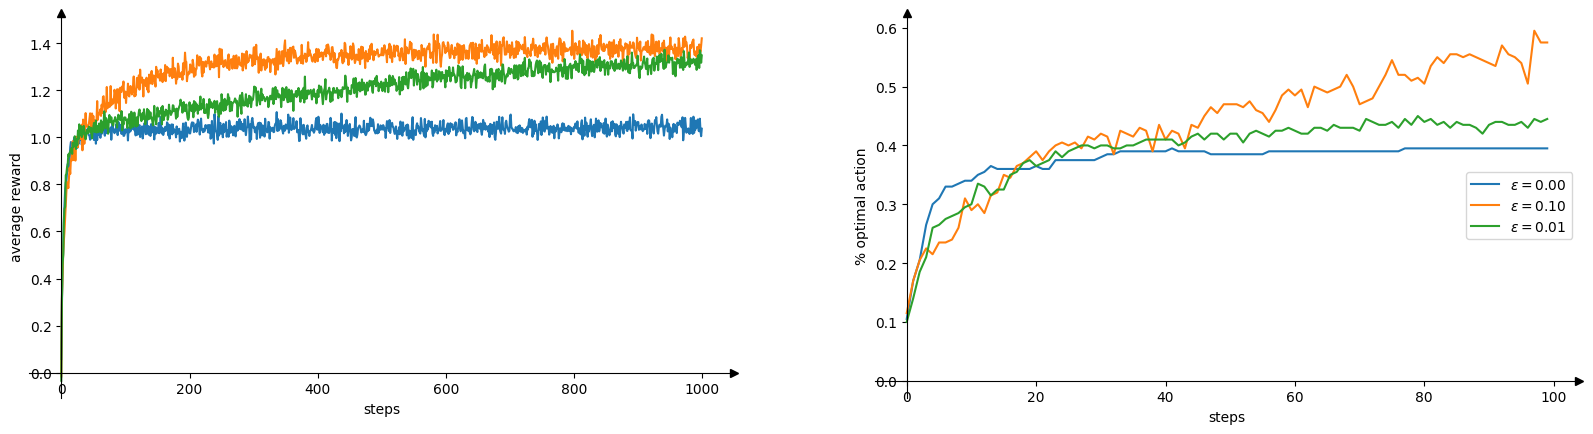

In [69]:
def figure_2_2(best_action_counts, rewards,figsize=(20, 5)):
    fig,axes=plt.subplots(1,2,figsize=figsize)
    for eps, reward in zip(epsilons, rewards):
        axes[0].plot(reward, label='$\epsilon = %.02f$' % (eps))
    axes[0].set_xlabel('steps')
    axes[0].set_ylabel('average reward')

    for eps, counts in zip(epsilons, best_action_counts):
        axes[1].plot(counts, label='$\epsilon = %.02f$' % (eps))
    axes[1].set_xlabel('steps')
    axes[1].set_ylabel('% optimal action')
    usda_vis.plot_style_axis_A(axes[0])
    usda_vis.plot_style_axis_A(axes[1])
    plt.legend(loc=5)
    plt.show()
    
figure_2_2(best_action_counts, rewards)

下面打印了$\epsilon=0.1$，在`time=1000`次时期望收益`q_true`、动作价值`q_estimation`、动作计数`action_count`等状态值。

In [114]:
bandit=bandits[1]
print(f'time:\t{bandit.time};\
    \nq_true:\t{np.around(bandit.q_true,3)};\
    \nq_estimation:\t{np.around(bandit.q_estimation,3)};\
    \naction_count:\t{bandit.action_count};\
    \nbest_action:\t{bandit.best_action};\
    \naverage_reward:\t{np.around(bandit.average_reward,3)};')

time:	1000;    
q_true:	[-1.055 -1.079  2.074 -0.71  -0.672 -1.416 -0.564  0.407 -0.659  0.057];    
q_estimation:	[-0.924 -0.749  2.117 -0.444 -0.6   -1.369 -0.625  0.338 -0.879 -0.01 ];    
action_count:	[ 11.   9. 846.   8.  15.  11.  14.  69.   7.  10.];    
best_action:	2;    
average_reward:	1.755;


### 3.9.1.2 （指数近因）加权平均（exponential recency-weighted average）和乐观初始值（Optimistic Initial Values）

使用采样平均方法估计动作价值，适用于收益的概率分布不随时间变化的赌博机问题，但是对于非平稳的强化学习问题，给近期的收益赋予比过去很久的收益更高的权值是一种合理的处理方式，将公式（2）用于更新$n-1$个过去收益的均值$Q_n$的增量更新规则调整为$Q_{n+1} \doteq Q_n+\alpha\left[R_n-Q_n\right]$，式中，步长参数$\alpha \in (0,1]$是一个常数，推导有

$$
\begin{aligned}
Q_{n+1}= & Q_n+\alpha\left[R_n-Q_n\right] \\
= & \alpha R_n+(1-\alpha) Q_n \\
= & \alpha R_n+(1-\alpha)\left[\alpha R_{n-1}+(1-\alpha) Q_{n-1}\right] \\
= & \alpha R_n+(1-\alpha) \alpha R_{n-1}+(1-\alpha)^2 Q_{n-1} \\
= & \alpha R_n+(1-\alpha) \alpha R_{n-1}+(1-\alpha)^2 \alpha R_{n-2}+  \cdots+(1-\alpha)^{n-1} \alpha R_1+(1-\alpha)^n Q_1 \\
= & (1-\alpha)^n Q_1+\sum_{i=1}^n \alpha(1-\alpha)^{n-i} R_i 
\end{aligned}
$$

使得$Q_{n+1}$成为对过去的收益和初始的估计$Q_1$的加权平均，可以验证$(1-a)^n+\sum_{i=1}^n \alpha(1-\alpha)^{n-i}=1$。赋予收益$R_i$的权值$\alpha(1-\alpha)^{n-i}$依赖于它被观测到的具体时刻与当前时刻的差，即$n-i$。因为$1-\alpha$小于1，因此赋予$R_i$的权值随着相隔次数的增加而递减（以指数形式递减），因此也称为指数近因加权平均。

上述试验初始化动作价值$Q_1(a)$时为0，为动作收益真实值的均值（因为采样于均值为0和方差为1的标准正态分布）。如果初始化动作价值为 +5 ，从前文打印的10个老虎机收益分布的小提琴图 (ViolinPlot)可以得知，+5 是一个非常乐观的初始化值。从下述打印的比较结果可以观察到，在平稳问题上，乐观初始动作价值是有效的，虽然开始迭代阶段波动较大，因为需要更多的“试探”而表现糟糕，但是随着时间的推移，最终获得了较高且平稳的动作的价值。但需要注意，任何仅仅关注初始条件的方法都不太可能对一般的非平稳情况有帮助（开始时刻仅出现一次，因此不应该过多的关注）。

In [7]:
runs=2000
time=1000

bandits = []
bandits.append(chapter02.Bandit(epsilon=0, initial=5, step_size=0.1))
bandits.append(chapter02.Bandit(epsilon=0.1, initial=0, step_size=0.1))
best_action_counts, _ = chapter02.simulate(runs, time, bandits)

100%|█████████████████████████████████████████████| 2000/2000 [01:07<00:00, 29.81it/s]


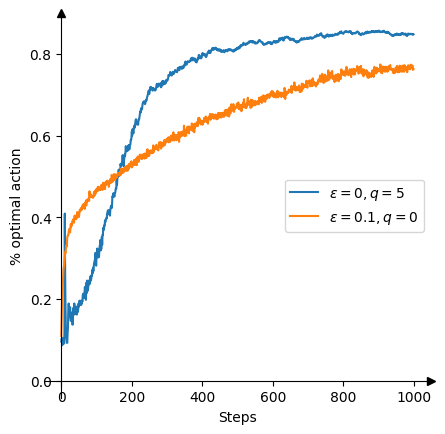

In [12]:
def figure_2_3(best_action_counts,figsize=(5, 5)):
    fig,ax=plt.subplots(figsize=figsize)
    ax.plot(best_action_counts[0], label='$\epsilon = 0, q = 5$')
    ax.plot(best_action_counts[1], label='$\epsilon = 0.1, q = 0$')
    ax.set_xlabel('Steps')
    ax.set_ylabel('% optimal action')
    plt.legend(loc='right')
    usda_vis.plot_style_axis_A(ax)
    plt.show()

figure_2_3(best_action_counts)

### 3.9.1.3 基于置信度上界（ Upper-Conﬁdence-Bound，UCB）的动作选择

动作-价值估计总是存在不确定性，但是上述试验在估计了动作价值后，开发/试探权衡中的“开发”总是选择具有最大估计价值的动作，因此最好是根据各个动作的潜力来选择可能事实上最优的动作，从而需要考虑各自的价值估计有多接近最大值，及其估计的不确定性，调整“开发”的动作选择公式，有$A_t \doteq \underset{a}{\arg \max }\left[Q_t(a)+c \sqrt{\frac{\ln t}{N_t(a)}}\right]$，式中，$\ln t$表示时刻$t$的自然对数（即$e  \approx  2.71828 $的多少次方等于$t$）；$N_t(a)$表示在时刻$t$之前动作$a$被选择的次数；$c$是一个大于0的常数，控制变化幅度，决定了置信水平。如果$N_t(a)=0$，则认为$a$是满足最大化条件的动作。

基于 UCB 选择的思想是平方根项是对动作$a$价值估计的不确定性或方差的度量。由于$N_t(a)$出现在不确定项的分母上，因此随着$N_t(a)$的增加，该项减小，不确定性可能会减小；如果$N_t(a)$没有变化，而随着时刻$t$的增加，不确定性则可能会增加。自然对数的使用意味着随着时间的推移，增加会变得越来越小，但它是无限的。所有动作都会被选中，但是随着时间的流逝，具有较低价值估计的动作或已经被选择了更多次的动作被选择到的频率较低。

UCB 代码实现为， 

```python
if self.UCB_param is not None:
    UCB_estimation = self.q_estimation + self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))        
    q_best = np.max(UCB_estimation)
    return np.random.choice(np.where(UCB_estimation == q_best)[0])
```

下述试验结果也验证了 UCB 算法的可行性，相较$\epsilon=0.1$的平均收益曲线，UCB 方法相对收敛到更高的平均收益水平上。

In [13]:
runs=2000
time=1000

bandits = []
bandits.append(chapter02.Bandit(epsilon=0, UCB_param=2, sample_averages=True))
bandits.append(chapter02.Bandit(epsilon=0.1, sample_averages=True))
_, average_rewards = chapter02.simulate(runs, time, bandits)

100%|█████████████████████████████████████████████| 2000/2000 [01:10<00:00, 28.40it/s]


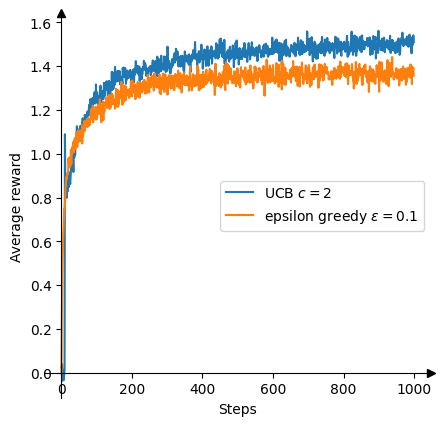

In [15]:
def figure_2_4(average_rewards,figsize=(5, 5)):
    fig,ax=plt.subplots(figsize=figsize)
    ax.plot(average_rewards[0], label='UCB $c = 2$')
    ax.plot(average_rewards[1], label='epsilon greedy $\epsilon = 0.1$')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Average reward')
    plt.legend(loc='right')
    usda_vis.plot_style_axis_A(ax)
    plt.show()
    
figure_2_4(average_rewards)    

### 3.9.1.4 梯度（Gradient）赌博机算法

针对每个动作$a$，考虑学习一个数值偏好（numerical preference）$N_t(a)$，偏好越大，对应的动作被选择的几率就越大，依据 softmax 分布（吉布斯（Gibbs）或玻尔兹曼（Boltzmann）分布）确定动作概率，$\operatorname{Pr}\left\{A_t=a\right\} \doteq \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}} \doteq \pi_t(a)$，式中，$\pi_t(a)$表示动作$a$在时刻$t$被选择的概率。对应的代码实现为，


```python
if self.gradient:
    exp_est = np.exp(self.q_estimation)
    self.action_prob = exp_est / np.sum(exp_est)
    return np.random.choice(self.indices, p=self.action_prob)
```


基于随机梯度上升（stochastic gradient ascent）的思想，存在一种求解 soft-max 动作偏好（soft-max action preferences）的自然学习算法，每一时刻$t$，在选择动作$A_t$并获得收益$R_t$后，动作偏好（动作价值估计）更新为$
H_{t+1}\left(A_t\right) \doteq H_t\left(A_t\right)+\alpha\left(R_t-\bar{R}_t\right)\left(1-\pi_t\left(A_t\right)\right), \quad \text { and } \\  H_{t+1}(a) \doteq H_t(a)-\alpha\left(R_t-\bar{R}_t\right) \pi_t(a), \quad \text { for all } a \neq A_t$，式中，$\alpha$是一个大于0的数，表示步长；$\bar{R}_t \in \mathbb{R}$是在时刻$t$内所有收益的平均值，作为比较收益的一个基准项。如果收益高于基准项，那么在未来选择动作$A_t$的概率就会增加，反之概率就会降低，而未选择的动作被选中的概率上升。对应的代码实现为，


```python
elif self.gradient:
    one_hot = np.zeros(self.k)
    one_hot[action] = 1
    if self.gradient_baseline:
        baseline = self.average_reward
    else:
        baseline = 0
    self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
```

下述试验梯度赌博机算法，配置真实的期望收益为 +4，在给定收益基准项（reward baseline term）（即平均收益）时，所有动作的价值估计可以马上适应到新的收益水平；如果没有基准项（$\bar{R}_t =0$），性能显著降低。

In [16]:
runs=2000
time=1000

bandits = []
bandits.append(chapter02.Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
bandits.append(chapter02.Bandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4))
bandits.append(chapter02.Bandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4))
bandits.append(chapter02.Bandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4))
best_action_counts, _ = chapter02.simulate(runs, time, bandits)

100%|█████████████████████████████████████████████| 2000/2000 [01:41<00:00, 19.62it/s]


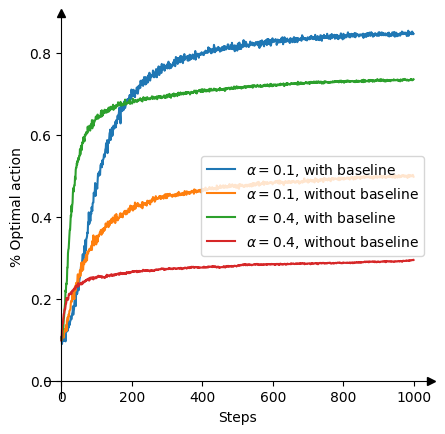

In [17]:
def figure_2_5(best_action_counts,figsize=(5, 5)):
    labels = [r'$\alpha = 0.1$, with baseline',
              r'$\alpha = 0.1$, without baseline',
              r'$\alpha = 0.4$, with baseline',
              r'$\alpha = 0.4$, without baseline']
    
    fig,ax=plt.subplots(figsize=figsize)
    for i in range(len(bandits)):
        ax.plot(best_action_counts[i], label=labels[i])
    ax.set_xlabel('Steps')
    ax.set_ylabel('% Optimal action')
    plt.legend(loc='right')
    usda_vis.plot_style_axis_A(ax)
    plt.show()

figure_2_5(best_action_counts)

## 3.9.2 

In [1]:
!pip install gymnasium
!pip install -q swig
!pip install -q gymnasium[box2d]

  Obtaining dependency information for gymnasium from https://files.pythonhosted.org/packages/a8/4d/3cbfd81ed84db450dbe73a89afcd8bc405273918415649ac6683356afe92/gymnasium-0.29.1-py3-none-any.whl.metadata
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)


In [1]:
import gymnasium as gym
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()

for _ in range(1000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

In [6]:
import gymnasium as gym

In [17]:
print(observation, reward, terminated, truncated, info)

[ 0.21294078  0.36693278  0.23810712 -1.1670104   0.35788667  0.23703547
  0.          0.        ] -1.6693451243501432 False False {}


---

In [1]:
import torch
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

cpu


In [5]:
gym.envs.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV21Environment-v0', 'GymV26Environment-v0'])